In [1]:
import pandas as pd
import os
from matplotlib import pylab as plt
import numpy as np
from pyteomics import mzml, fasta, parser
from matplotlib.collections import PatchCollection
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from  sklearn.decomposition import PCA
from umap.umap_ import UMAP
from collections import defaultdict
import seaborn as sns

In [2]:
# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors):
        self.colors = colors
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height, 
                           facecolor=c, 
                           edgecolor='black'))

        patch = PatchCollection(patches, match_original=True)

        handlebox.add_artist(patch)
        return patch

## Functions

In [3]:
def get_spectronaut_res_a549(work_dir, label):
    '''Reads Spectronauts results for A549 cell line and prepare IDs values'''
    out = []
    indexes = []
    for f in os.listdir(work_dir):
        data = {}
        df = pd.read_table(os.path.join(work_dir, f))
        df.index = df["Parameter"]
        df = df["Value"].to_dict()
        data["file"] = f.split(".")[0]
        data["index"] = f.split(".")[0].split("_")[-1]
        data[label] = 0 if df['Protein Groups'].split(" of")[0].replace("\xa0", "")=="NA" else int(df['Protein Groups'].split(" of")[0].replace("\xa0", "")) 
        out.append(pd.Series(data))
    oout = pd.concat(out, axis=1).T
    oout.index = oout["index"]
    return  oout

In [4]:
def get_names(s):
    p = s.split(".")[0].split("_")[-1]
    if "blank" in s:
        return "blank"
    elif "20xSC" in s:
        return "20xSC"
    elif "40xSC" in s:
        return "40xSC"
    elif p[1:] == "18" or p[1:] == "19":
        return "SC_20-25"
    elif p[1:] == "16" or p[1:] == "17":
        return "SC_25-30"
    elif p[1:] == "20" or p[1:] == "21":
        return "SC_15-20"
    else:
        return None

In [5]:
def blank_filter(col, analysis, thresh=4):
    # print(analysis)
    out = []
    for num in col:
        if blanks[analysis] * thresh < num:
            out.append( num)
        else:
            out.append(np.nan)
    return out

In [6]:
def get_spectronaut_res(work_dir, inj=None, analysis=None, method=None, sample=None):
    out = []
    for f in os.listdir(work_dir):
        data = {}
        df = pd.read_table(os.path.join(work_dir, f), low_memory=False)
        df.index = df["Parameter"]
        df = df["Value"].to_dict()
        data["file"] = f.split(".")[0]
        data["LC, min"] = float(df["Gradient Length [min]"])
        data["Median FWHM, s"] = round(float(df["Median FWHM"].split(' ')[0])*60, 2)
        data["Data Points per Peak (MS1)"] = float(df["Data Points per Peak (MS1)"].split(' ')[0])
        data["Data Points per Peak (MS2)"] = float(df["Data Points per Peak (MS2)"].split(' ')[0])
        data["Precursors"] =  0 if df["Precursors"].split(" of")[0].replace("\xa0", "")=="NA" else int(df["Precursors"].split(" of")[0].replace("\xa0", ""))
        data["Precursors_all"] = int(df["Precursors"].split(" ")[2].replace("\xa0",""))
        data["PG"] = 0 if df['Protein Groups'].split(" of")[0].replace("\xa0", "")=="NA" else int(df['Protein Groups'].split(" of")[0].replace("\xa0", "")) 
        data["PG_all"] = int(df['Protein Groups'].split(" of")[1].replace("\xa0", ""))
        data["Sample"] = sample
        data["injection"] = inj
        data["analysis"] = analysis
        data["method"] = method
        data["experiment"] = work_dir.split("/")[-3]
        data["path"] = df['Raw File Name']
        out.append(pd.Series(data))
    return  pd.concat(out, axis=1).T

In [7]:
def get_experiment_statistics(df):
    df = df.reset_index()
    experiment = {}
    experiment["experiment"] = df.experiment.loc[0]
    experiment["LC"] = df["LC, min"][0]
    experiment["Sample"] = df.Sample[0]
    experiment["injection"] = df.injection[0]
    experiment["analysis"] = df.analysis[0]
    experiment["method"] = df.method[0]
    experiment["PG_mean"] = df.PG.mean()
    experiment["PG_std"] = df.PG.std()
    experiment["PG"] = [list(df.PG)]
    experiment["PG_all"] = df.PG_all[0]
    experiment["DPPP_MS1"] = df["Data Points per Peak (MS1)"][0]
    experiment["DPPP_MS2"] = df["Data Points per Peak (MS2)"][0]
    experiment["Precursors_mean"] = df.Precursors.mean()
    experiment["Precursors_std"] = df.Precursors.std()
    experiment["Precursors"] = [list(df.Precursors)]
    experiment["Precursors_all"] = df.Precursors_all[0]
    experiment["FWHM, s"] = df["Median FWHM, s"].mean()
    experiment["folder"] = df.experiment[0]
    experiment["name"] = "\n".join(["_".join([df.Sample[0], df.injection[0]]), df.method[0], df.analysis[0]])  
    experiment["short_name"] =  "_".join([df.injection[0], df.analysis[0]])
    return pd.DataFrame(experiment)

In [8]:
xcoord = {i:j for j, i in enumerate('ABCDEFGHIJKLMNO', 1)}
def get_diamerter(coord):
    # coord = position.split(':')[1]
    xpos = xcoord[coord[0]]
    ypos = 25 - int(coord[1:])
    if diameters[(diameters["XPos"]== xpos) & (diameters["YPos"]== ypos)].shape[0] > 1:
        print(coord, diameters[(diameters["XPos"]== xpos) & (diameters["YPos"]== ypos)])
    return diameters[(diameters["XPos"]== xpos) & (diameters["YPos"]== ypos)]['Diameter'].mean()
def get_elongation(coord):
    # coord = position.split(':')[1]
    xpos = xcoord[coord[0]]
    ypos = 25 - int(coord[1:])
    if diameters[(diameters["XPos"]== xpos) & (diameters["YPos"]== ypos)].shape[0] > 1:
        print(coord, diameters[(diameters["XPos"]== xpos) & (diameters["YPos"]== ypos)])
    return diameters[(diameters["XPos"]== xpos) & (diameters["YPos"]== ypos)]['Elongation'].mean()

In [9]:
def get_color(s):
    if "blank" in s:
        return "black"
    elif "20xSC" in s:
        return "orange"
    elif "40xSC" in s:
        return "red"
    elif s[1:] == "18" or s[1:] == "19":
        return "green"
    elif s[1:] == "16" or s[1:] == "17":
        return "yellow"
    elif s[1:] == "20" or s[1:] == "21":
        return "blue"
    else:
        return None

## load and save data from Spectronaut results

### A549 IDs

In [76]:
labels = ["Method Evaluation", "DirectDIA+","DirectDIA+, OS", "Library Search (20cells)",  "Library Search (40cells)", ]
conditions = ["blanks", '$15-20\ \mu m$','$20-25\ \mu m$', '$25-30\ \mu m$',]
x_label = ['blank', 'SC_15-20', 'SC_20-25', 'SC_25-30',]

In [77]:
root = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/A549_cells/"

dirs = ["20240206_123701_MM_AstralPaper_A549_method_eval_mode/RunSummaries/",
        "20240206_123905_MM_AstralPaper_A549_DirectDIA_MBR/RunSummaries/",
        "20240813_203441_MM_Astral_paper_A549_Figure7_MBR_perGroup_directDIA_strictFDR/RunSummaries/",
        "20240206_124255_MM_AstralPaper_LibrarySearch_20x/RunSummaries/",
        "20240206_124359_MM_AstralPaper_LibrarySearch_40x/RunSummaries/", 
       ]

In [78]:
cdir = dirs[1]
data = []
for cdir, xlabel in zip(dirs, labels):
    data.append(get_spectronaut_res_a549(os.path.join(root, cdir), xlabel))
df = data[0]
for i in data[1:]:
    df = df.merge(i, how="outer", on='file')

In [79]:
data_a459 = df.loc[:, ["file"] + labels]
data = df.loc[:, ["file"] + labels]
data["labels"] = data.file.apply(get_names)
data["position"] = data["file"].apply(lambda x: x.split(".")[0].split("_")[-1])
data.index=data.position
blanks = data[data.labels=="blank"].mean().to_dict()
data.loc[data.labels !="blank", labels] = data.loc[data.labels !="blank", labels].apply(lambda x: blank_filter(x, x.name), axis=0)

In [80]:
data.to_csv("./serialized_data/fig4/f4_paneld_a549_ids.csv", index=False)

In [81]:
# data

In [82]:
data.groupby("labels").mean()

,Method Evaluation,DirectDIA+,"DirectDIA+, OS",Library Search (20cells),Library Search (40cells)
labels,,,,,
20xSC,NaN,NaN,5835.666667,NaN,NaN
40xSC,NaN,NaN,6420.333333,NaN,NaN
SC_15-20,1800.708333,3304.000000,2256.166667,3350.916667,3220.708333
SC_20-25,2180.782609,3796.217391,2638.304348,3895.173913,3786.739130
SC_25-30,2870.421053,4439.157895,3344.421053,4688.631579,4650.052632
blank,172.000000,384.666667,176.333333,419.333333,253.000000


### PCA plot

In [83]:
prot = pd.read_table("/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/A549_cells/20240206_123905_MM_AstralPaper_A549_DirectDIA_MBR/MM_AstralPaper_A549_DirectDIA_MBR_Report_Protein_JB (Pivot).tsv")
prot.index = prot["PG.ProteinGroups"]

In [84]:
cols = [x for x in prot.columns if ("PG.Quantity" in x) and ("blank" not in x)]
quant_df = prot.loc[:, cols]
quant_df.rename({k: k.split(".")[0].split("_")[-1] for k in quant_df.columns}, axis=1, inplace=True)
quant_df.dropna(thresh=20, inplace=True)
quant_df = quant_df.apply(lambda x: np.log2(x), axis=1)
quant_df_mean = quant_df.mean()
quant_df_std = quant_df.std()
quant_df = quant_df.apply(lambda x: (x - quant_df.mean()) / quant_df.std(), axis=1)
quant_df.fillna(quant_df.min().min(), inplace=True)

In [85]:
sizes = pd.read_table("/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/backup_not_for_upload/20231108_LF_SCP_run56_CellenONE_data/A549_15-20um_20231108_141126_789.Run/20231108_141128.457__isolated.xls")
diameters = sizes.groupby(by='DropNo').apply(lambda x: np.mean(x))

In [86]:
files = ["/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/backup_not_for_upload/20231108_LF_SCP_run56_CellenONE_data/A549_15-20um_20231108_141126_789.Run/20231108_141128.457__isolated.xls", 
         "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/backup_not_for_upload/20231108_LF_SCP_run56_CellenONE_data/A549_20-25um_20231108_140632_647.Run/20231108_140634.209__isolated.xls",
        "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/backup_not_for_upload/20231108_LF_SCP_run56_CellenONE_data/A549_35-30um_20231108_133549_579.Run/20231108_133551.328__isolated.xls"]
dim_data = []
for file in files:
    sizes = pd.read_table(file)
    dim_data.append(sizes.groupby(by='DropNo').apply(lambda x: np.mean(x)))
diameters = pd.concat(dim_data)

In [87]:
pca = PCA(n_components = 3)
principalComponents = pca.fit_transform(quant_df.T)
pca.explained_variance_ratio_

array([0.30113177, 0.05430727, 0.03021787])

In [88]:
principalDf = pd.DataFrame(data = principalComponents, \
                           columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf["position"] = quant_df.columns
principalDf.index = principalDf.position
principalDf['diameter']  = principalDf.position.apply(get_diamerter)
principalDf["elongation"] = principalDf.position.apply(get_elongation)

### umap

In [89]:
umap_2d = UMAP(random_state=0)
umap_2d.fit(quant_df.T)
projections = umap_2d.transform(quant_df.T)
UmapDf = pd.DataFrame(data = projections, columns = ['umap1', 'umap2', ])
UmapDf['names'] = [get_names(y) for y in quant_df.columns]
UmapDf['colors'] = [get_color(y) for y in quant_df.columns]
UmapDf["position"] = quant_df.columns
UmapDf.index = UmapDf.position

In [90]:
data_pca_umap_a549 = pd.concat([principalDf, UmapDf], axis=1)
data_pca_umap_a549.to_csv("./serialized_data/fig4/f4_panelef_a549_pca_umap.csv", index=False)

In [104]:
df = pd.concat([data_pca_umap_a549, quant_df.loc[protein_list,:].T], axis=1)
df.loc[:, ["names", "principal component 1", "principal component 2", "umap1", "umap2"] + protein_list]\
  .to_csv("serialized_data/main_exf1.csv", sep="\t", index=False )

In [27]:
## for extended figure 1
protein_list = ['P60709;P63261', 'P68032',  'P62805', 'P10412',  'Q9H1E3', 'P06493', "P46013"]
pd.concat([data_pca_umap_a549, quant_df.loc[protein_list,:].T], axis=1).to_csv("./serialized_data/exfig/exf2_a549.csv", index=False, )

### H460 and A549 dataset

In [105]:
#ids
all_data = []
working_dir = "/groups/protechhub/user/Manuel/Spectronaut_results/SNv18/LFSCP_run69p2/20240616_211846_MM_run62p2_revision_50SPD_25cmIO_all_MEpergroup/"
df = get_spectronaut_res(os.path.join(working_dir, "runsummaries_edited/"), 
                         inj="SC", 
                         analysis='MBR',
                         method="?", 
                         sample="?")
df.Sample = df.file.apply(lambda x: x.split("_")[7])
df.method = df.file.apply(lambda x: "_".join(x.split("_")[2:7]))
df["experiment"] = df.file.apply(lambda x: "_".join(x.split("_")[7:8] + ["MBR"]))
all_data.append(df.groupby("experiment").apply(get_experiment_statistics))
data_all = pd.concat(all_data).fillna(0)
data_all.index = data_all.experiment
# data_all

In [106]:
data_all.columns

Index(['experiment', 'LC', 'Sample', 'injection', 'analysis', 'method',
       'PG_mean', 'PG_std', 'PG', 'PG_all', 'DPPP_MS1', 'DPPP_MS2',
       'Precursors_mean', 'Precursors_std', 'Precursors', 'Precursors_all',
       'FWHM, s', 'folder', 'name', 'short_name'],
      dtype='object')

In [107]:
data_all.loc[:, ["Sample", "injection", "analysis", "PG", "PG_mean", "PG_std", 'Precursors',   'Precursors_mean', 'Precursors_std']].to_csv("serialized_data/main_f4.csv", index=False)

In [108]:
    data_all.to_parquet("serialized_data/fig4/f4_panela_a549_h460_ids.parquet", index=False)
data_all.to_csv("serialized_data/fig4/f4_panela_a549_h460_ids.csv", index=False)

In [109]:
#Quant_data
prot = pd.read_table("/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/run69p2_revision_top20cells/20240701_100039_MM_run62p2_revision_50SPD_25cmIO_all_MEpergroup_Proteins.tsv")
prot.index = prot["PG.ProteinGroups"]

In [110]:
cols = [x for x in prot.columns if ("PG.Quantity" in x )]#and "blank" not in x)]
quant_df = prot.loc[:, cols]#.fillna(0)
quant_df.rename({k: "_".join(k.split(".")[0].split("_")[7:10:2]) for k in quant_df.columns}, axis=1, inplace=True)

quant_df.dropna(how="all", inplace=True)
print(quant_df.shape)
quant_df.dropna(thresh=5, inplace=True)

print(quant_df.shape)

quant_df = quant_df.apply(lambda x: np.log2(x), axis=1)
quant_df = quant_df.apply(lambda x: (x - quant_df.mean()) / quant_df.std(), axis=1)
quant_df.fillna(quant_df.min().min(), inplace=True)

(5748, 50)
(5560, 50)


In [111]:
quant_df["PG"] = quant_df.index
quant_df.to_csv("serialized_data/fig4/f4_panelc.csv", index=False)

In [112]:
cols = ['PG', 'A549_A21', 'A549_A22', 'A549_A23', 'A549_A24', 'A549_B21', 'A549_B22',
       'A549_B23', 'A549_C11', 'A549_C12', 'A549_C13', 'A549_C14', 'A549_C15',
       'A549_C16', 'A549_C17', 'A549_C18', 'A549_C19', 'A549_C20', 'A549_C21',
       'A549_C22', 'A549_C23', 'blank_G21', 'blank_G22', 'blank_G23',
       'blank_G24', 'blank_H22', 'blank_H23', 'blank_H24', 'blank_I17',
       'blank_I19', 'blank_I21', 'H460_D21', 'H460_D22', 'H460_D23',
       'H460_D24', 'H460_E2', 'H460_E3', 'H460_E4', 'H460_F11', 'H460_F12',
       'H460_F13', 'H460_F14', 'H460_F15', 'H460_F16', 'H460_F17', 'H460_F18',
       'H460_F19', 'H460_F20', 'H460_F21', 'H460_F23', 'H460_F24' ]

In [113]:
quant_df.loc[:, cols].to_csv("serialized_data/main_f4_panelc.csv", index=False, sep='\t')

### pca

In [49]:
quant_df = pd.read_csv("serialized_data/fig4/f4_panelc.csv").set_index("PG")

In [50]:
pca = PCA(n_components = 3)
principalComponents = pca.fit_transform(quant_df.T)
pca.explained_variance_ratio_

array([0.58333599, 0.158075  , 0.06126766])

In [51]:
# cc_dict

In [52]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3'])

colors = ["#264d8c", "#44b7c2", "#a02c59", "#70b7c2", "#ffae49", "#625a65", "#aac1e8"]
cc_dict = {k:v for k, v in zip(set([y.split("_")[7] for y in [x for x in prot.columns if "PG.Quantity" in x]]), colors)}

principalDf['names'] = [y.split("_")[0] for y in quant_df.columns]
principalDf['files'] =  [x.split("_")[1] for x in quant_df.columns]
principalDf['colors'] = principalDf["names"].apply(lambda x: cc_dict[x])
principalDf["position"] = principalDf.apply(lambda x: x.names + "_" + x.files, axis=1)
principalDf.index = principalDf.apply(lambda x: x.names + "_" + x.files, axis=1)


In [54]:
# principalDf.loc

In [55]:
principalDf.to_csv("serialized_data/fig4/f4_panelb_pca_h460_a549.csv", index=False)

## panels

In [30]:
labels = ["Method Evaluation", "DirectDIA+","DirectDIA+, OS", "Library Search (20cells)",  "Library Search (40cells)", ]
conditions = ["blanks", '$15-20\ \mu m$','$20-25\ \mu m$', '$25-30\ \mu m$',]
x_label = ['blank', 'SC_15-20', 'SC_20-25', 'SC_25-30',]
colors = ["#264d8c", "#44b7c2", "#a02c59", "#70b7c2", "#ffae49", "#625a65", "#aac1e8"]

In [31]:
data_a549_h460_ids = pd.read_parquet("serialized_data/fig4/f4_panela_a549_h460_ids.parquet").set_index("experiment")
data_panelb = pd.read_csv("serialized_data/fig4/f4_panelb_pca_h460_a549.csv")
data_panelc = pd.read_csv("serialized_data/fig4/f4_panelc.csv").set_index("PG")

data_a549_ids = pd.read_csv("./serialized_data/fig4/f4_paneld_a549_ids.csv").set_index("position")
data_pca_umap_a549 = pd.read_csv("./serialized_data/fig4/f4_panelef_a549_pca_umap.csv").set_index("position")
explained_pca_a549 = [0.30113177, 0.05430727, 0.03021821]
explained_pca_a549_h460 = [0.58333599, 0.158075  , 0.06126766]

In [32]:
def plot_panela(ax, data_all):
    cols = [ 'A549_MBR', 'H460_MBR', 'blank_MBR']
    data = data_all.loc[cols,:]
    x = np.arange(data.shape[0]) 
    labels=['A549', 'H460', 'blank' ]
    w = 0.20
    bar_w = 0.3
    ax.set_ylabel('PG', color=colors[0])
    ax.bar(x - w, data["PG_mean"], yerr = data["PG_std"], color=colors[0], width=bar_w, label="PG")
    ax.tick_params(axis='y', labelcolor=colors[0])
    ax.set_ylim(0, 1.1 * max(data["PG_mean"]))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
    ax.set_ylim(0, 7000)
    ax.set_xticks(x, labels)
    for b , yy in zip(x - w, data["PG"]):
        xx = np.linspace(b - bar_w / 3, b + bar_w / 3, len(yy))
        ax.scatter(xx, yy, color=colors[0], edgecolors="black")
    for i, y in zip(x - w, data["PG_mean"]):
        t = ax.annotate(f'{int(y)}', xy=(i, 800 + y),  ha='center',)
    h, l = [], []
    # ------ append the multicolor legend patches
    h.append(MulticolorPatch([colors[0], colors[2]]))
    l.append("DirectDIA+, with matching")
    # ------ create the legend
    ax.legend(h, l, loc='upper left', 
             handler_map={MulticolorPatch: MulticolorPatchHandler()}, 
             bbox_to_anchor=(0.5, 0.95))
    
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Precursors', color=colors[2]) 
    ax2.bar(x + w, data["Precursors_mean"], yerr=data["Precursors_std"], color=colors[2], \
            width=bar_w, label="Precursors")
    ax2.tick_params(axis='y', labelcolor=colors[2])
    ax2.set_ylim(0, 1.1 * max(data["Precursors_mean"]))
    ax2.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
    y_annotation = []
    for b , yy in zip(x + w, data["Precursors"]):
        xx = np.linspace(b - bar_w / 3, b + bar_w / 3, len(yy))
        ax2.scatter(xx, yy, color=colors[2], edgecolors="black")
        y_annotation.append(max(yy))
    for i, y in zip(x + w, data["Precursors_mean"]):
        t = ax2.annotate(f'{int(y)}', xy=(i, 7000 + y),  ha='center')
    ax2.set_ylim(0,50000)


In [33]:
def plot_panelb(ax, data):
    for n in data.names.unique():
        d = data[data.names == n]
        ax.scatter(d['pc1'], d['pc2'], color=d["colors"], label=n, s=15)
    ax.legend(loc=1)
    ax.set_xlabel(f'PC1 ({(explained_pca_a549_h460[0] * 100):.1f}%)')
    ax.set_ylabel(f'PC2 ({(explained_pca_a549_h460[1] * 100):.1f}%)')

In [34]:
def plot_panelc(data):
    plt.rcParams['font.size'] = 7
    plt.rcParams['axes.titlesize'] = 7
    plt.rcParams['axes.labelsize'] = 7
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['figure.titlesize'] = 7
    g = sns.clustermap(data,method='ward', metric='euclidean', cmap='viridis', figsize=(3.4, 2.5),\
                       dendrogram_ratio=(0.1, 0.1),)
    reordered_cols = g.dendrogram_col.reordered_ind
    g.ax_heatmap.set_xticks(np.arange(len(reordered_cols)))
    g.ax_heatmap.tick_params(axis='both', which='both', length=0)
    g.ax_heatmap.set_xticklabels([""] * 5 +["blank"] + [""] * 14 +[ "A549"] + [""] * 19 +[ "H460"] + [""] * 9, \
                                 rotation=0)
    g.ax_heatmap.set_yticklabels([], rotation=0)
    g.ax_heatmap.set_ylabel("")
    g.ax_heatmap.tick_params(labelleft=False)
    plt.tight_layout()

In [35]:
def plot_panel_a549_1(ax, data, labels=labels, colors=colors):
    bar_w= 0.15
    for (shift, col), c in zip(enumerate(labels), colors):
        y = []
        yy = []
        y_std = []
        xx= np.arange(6) + bar_w * shift
        for l, x in zip(x_label, xx):
            d = data[data.labels == l]
            y.append(d[col].mean())
            y_std.append(d[col].std())
            ax.bar(x, d[col].mean(), yerr=d[col].std(), width=bar_w, color=c)
            dot_x = np.linspace(x - bar_w / 3, x + bar_w / 3, len(d))
            ax.scatter(dot_x, d[col],  color=c, edgecolors="black", s=10)
        legends.append(mpatches.Patch(color=c, label=col))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
    ax.set_ylabel("PG")
    ax.set_ylim(0, 8000)
    ax.set_xticks(list(np.arange(4) + 3 / 2 * bar_w), conditions)
    ax.legend(handles=legends)


In [36]:
def plot_panel_a549_2(ax, fig, data):
    ax.scatter(data['principal component 1'], data["principal component 2"], c=data["diameter"], s=22)
    norm = mcolors.Normalize(vmin=data['diameter'].min(), vmax=data['diameter'].max())
    cmap = plt.get_cmap('viridis')
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label=r"cell diameter, $\mu m$")
    ax.set_xlabel(f'PC 1 ({(explained_pca_a549[0] * 100):.1f}%)')
    ax.set_ylabel(f'PC 2 ({(explained_pca_a549[1] * 100):.1f}%)')
    

In [37]:
def plot_panel_a549_3(ax, fig, data):
    ax.scatter(data['umap1'], data["umap2"], c=data["diameter"], s=22)
    norm = mcolors.Normalize(vmin=data['diameter'].min(), vmax=data['diameter'].max())
    cmap = plt.get_cmap('viridis')
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label=r"cell diameter, $\mu m$")
    ax.set_xlabel(f'UMAP 1')
    ax.set_ylabel(f'UMAP 2')
    ax.annotate('G2/M phase', xy=(14.3, 9.5),  ha='left', color="black")
    ax.annotate('S phase', xy=(11, 9.5),  ha='left', color="black")
    ax.annotate('G1 phase', xy=(11.5, 12),  ha='left', color="black")

## figures

In [38]:
colors = ["#264d8c", "#44b7c2", "#a02c59", "#70b7c2", "#ffae49", "#625a65", "#aac1e8"]

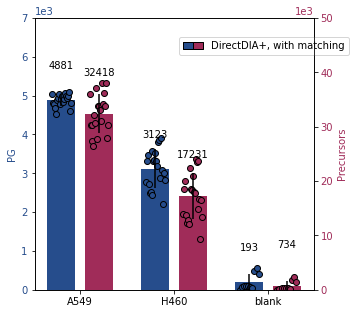

In [39]:
fig, ax = plt.subplots(1, 1 , figsize=(5 , 5))
plot_panela(ax, data_a549_h460_ids)

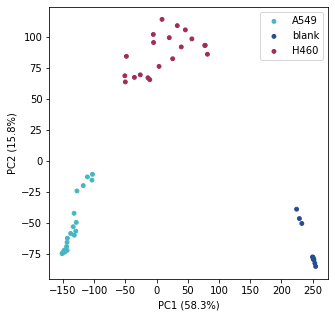

In [40]:
fig, ax = plt.subplots(1, 1 , figsize=(5 , 5))
plot_panelb(ax, data_panelb)

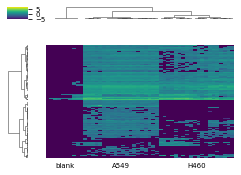

In [41]:
plot_panelc(data_panelc)
# plt.savefig("fig4_c.png", dpi=1000)
# plt.savefig("fig4_c.svg")
# plt.savefig("fig4_c.pdf")

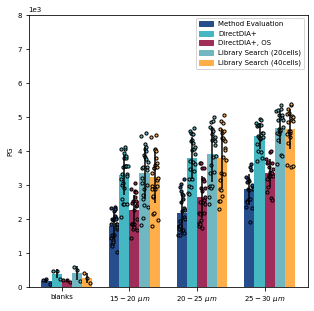

In [42]:
labels = ["Method Evaluation", \
          "DirectDIA+", "DirectDIA+, OS",\
          "Library Search (20cells)", \
          "Library Search (40cells)"]
conditions = ["blanks", '$15-20\ \mu m$','$20-25\ \mu m$', '$25-30\ \mu m$']
x_label = ['blank', 'SC_15-20', 'SC_20-25', 'SC_25-30',]
colors=["#5f8bd3", "#366ec9", "#264d8c", "#1b3764", "#002255"]
col = "Method Evaluation"
legends = []
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))
plot_panel_a549_1(ax1, data_a549_ids)

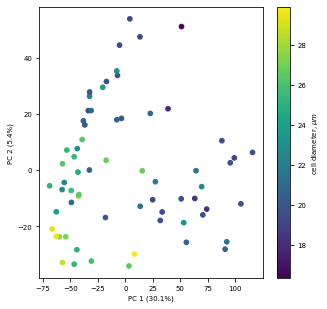

In [43]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
plot_panel_a549_2(ax1, fig,  data_pca_umap_a549)

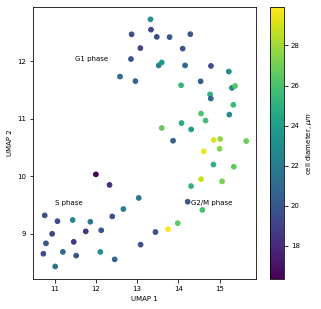

In [44]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
plot_panel_a549_3(ax1, fig,  data_pca_umap_a549)